In [2]:
try:
    from google.colab import drive
    COLAB_NOTEBOOK = True
except:
    COLAB_NOTEBOOK = False
if COLAB_NOTEBOOK:
    drive.mount("/content/gdrive", force_remount=True)
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# tf.config.set_visible_devices([], 'GPU') 
import h5py
import random
import time
tf.executing_eagerly() 


True

In [3]:
# Set CPU as available physical device


# To find out which devices your operations and tensors are assigned to

# Create some tensors and perform an operation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)





tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
# drive.flush_and_unmount()

In [4]:
# Install sonnet (it doesn't come preinstalled in the colab VM).
if COLAB_NOTEBOOK:
    !pip install -q dm-sonnet

!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'


 GeForce GTX 650


In [5]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import time
import sonnet as snt
from tqdm import tqdm

print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))
print("    Numpy  version: {}".format(np.__version__))
from tensorboard import version; print("TensorBoard version: {}".format(version.VERSION))
# tf.config.list_physical_devices('GPU')

TensorFlow version: 2.1.0
    Sonnet version: 2.0.0
    Numpy  version: 1.18.2
TensorBoard version: 2.2.0


In [6]:
class ConvMaxPool(snt.Module):
    def __init__(self, name=None):
        super(ConvMaxPool, self).__init__(name=name)
        self.conv = snt.Conv1D(output_channels=64, kernel_shape=64, stride=1, rate=1,
                               padding="SAME", with_bias=True,
                               data_format="NWC", name="conv_max_pool"
                               )

    def __call__(self, inputs):
        features = self.conv(inputs)
        outputs = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="VALID", 
                                   data_format='NWC', name="pool") #64×1024
        return outputs


class CNN(snt.Module):
    def __init__(self, epsilon, name=None):
        super(CNN, self).__init__(name=name)
        self.layers = [
            ConvMaxPool(name="conv"+str(ii))
            for ii in range(6)
        ]
        self.conv_in = snt.Conv1D(output_channels=64, kernel_shape=2, stride=1, rate=1,
                       padding="SAME", with_bias=True,
                       data_format="NWC", name="conv_input"
                       )

        self.linear = snt.Linear(output_size=128, with_bias=True)
        self.linear1 = snt.Linear(output_size=128, with_bias=True)
        self.linear2 = snt.Linear(output_size=24, with_bias=True)        
        self.decay_lr = 0
        self.lr=2e-4


    # @snt.once
    def __initialize(self, weight):
        pass

    def __call__(self, inputs):
        features = self.conv_in(inputs) #2×1024
        features = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="VALID", 
                                    data_format='NWC', name="pool_input") 
#         print(features)
        for layer in self.layers:
            features = layer(features)    
        features = snt.flatten(features)

        features = self.linear(features)
        features = tf.nn.relu(features)
        features = self.linear1(features)
        features = tf.nn.relu(features)

        output = self.linear2(features)        
#         output = tf.nn.softmax(features)
        return output

opt = snt.optimizers.Adam(learning_rate=0.001, beta1=0.)

def step(batch, labels):
    with tf.GradientTape() as tape:
        logits = radio_model(batch)
#         loss = cross_entropy_loss(logits, labels)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
        loss = tf.reduce_mean(loss)

    params = radio_model.trainable_variables
    grads = tape.gradient(loss, params)        
    
#     if self.decay_lr:
#       self.lr.assign(self.init_lr * lr_mult)
    
    opt.apply(grads, params)
    return loss

def cross_entropy_loss(logits, target):
    return -tf.reduce_sum(target*tf.math.log(logits))



In [7]:
class radioML:
    def __init__(self, file, batch_size):
        self.file = file
        self.batch_size = batch_size

    def __call__(self):
        with h5py.File(self.file, 'r') as f:
            datasize = len(f['X'])
            while True:
                idxs = random.sample(range(datasize), self.batch_size)
                yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                # f.close()

def radioML_map(data_batch, data_label):
#     print(data_batch.shape)
    data_batch = tf.reshape(data_batch, [1024, 2])
#     mean = tf.math.reduce_mean(data_batch)
#     std = tf.math.reduce_std(data_batch)
#     data_batch = (data_batch - mean)/std
#     print(std, mean)
#     print(type(std))
    return (data_batch, data_label)

In [8]:
radio_model = CNN(epsilon=1e-8, name="CNN")
print(radio_model)


CNN(epsilon=1e-08, name='CNN')


(1024, 2)


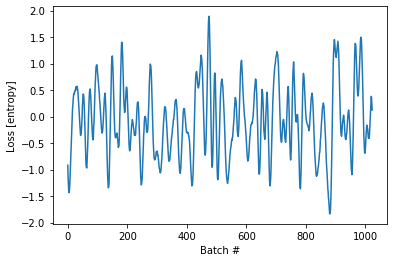

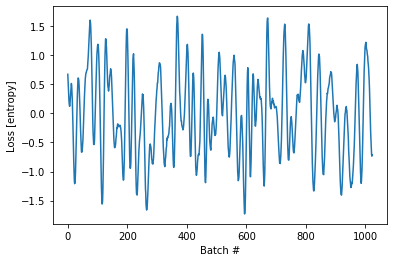

In [9]:
if COLAB_NOTEBOOK:
    hdf5_path = '/content/gdrive/My Drive/data/GOLD_XYZ.hdf5'
else:          
    hdf5_path = '/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
    
    


radio_plot = tf.data.Dataset.from_generator(radioML(hdf5_path, 1), 
                output_types=(tf.float32, tf.float32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_plot = radio_plot.take(1)
radio_plot = radio_plot.map(radioML_map)
for (batch, labels) in radio_plot:    
    print(batch.shape)
    fig1 = plt.figure()
    plt.plot(batch[:,0])
    plt.xlabel('Batch #')
    plt.ylabel('Loss [entropy]')
    fig2 = plt.figure()
    plt.plot(batch[:,1])
    plt.xlabel('Batch #')
    plt.ylabel('Loss [entropy]')
    plt.show()

In [11]:
%reload_ext tensorboard
# %load_ext tensorboard
# import os
from datetime import datetime as dt
# Clear any logs from previous runs
!rm -rf ./logs/
log_dir = "logs/scalars/" + dt.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(log_dir)


writer.set_as_default()

In [17]:

batch_size = 128
num_batches = 256
num_epochs = 10

t = tqdm(range(num_batches * num_epochs),
                                unit='sig', unit_scale=batch_size,
                                position=0)


radio_data = tf.data.Dataset.from_generator(radioML(hdf5_path, 1), 
                output_types=(tf.float32, tf.float32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

loss_history = []
loss = 0
step_num=0
radio_data = radio_data.take(batch_size*num_batches)
radio_data = radio_data.map(radioML_map)
radio_data = radio_data.batch(batch_size)
radio_data = radio_data.prefetch(tf.data.experimental.AUTOTUNE)
radio_data = radio_data.repeat(num_epochs)
# radio_data = radio_data.cache()
start_time = time.perf_counter()
for step_num,(batch, labels) in enumerate(radio_data):      
    epoch = tf.constant(int(step_num / (batch_size*num_batches)))
    loss = step(batch, labels)
    step_num+=1
    with writer.as_default():
        tf.summary.scalar('training loss', loss, step=i)
    
    t.update(1)
    if step_num and (step_num % batch_size*num_batches == 0):
        t.write('\nEpoch = {}/{} (lr_mult = {:0.02f}, loss = {}) done.'.format(
            epoch.numpy(), num_epochs, 0.001, loss.numpy()))
tf.print("Execution time:", time.perf_counter() - start_time)   
t.close()
# tf.print("batch.shape: ", i, batch.shape)  
# tf.print(loss_history)                        

  5%|▌         | 16384/327680 [04:02<1:19:45, 65.05sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 2.7762327194213867) done.


 10%|█         | 32768/327680 [07:50<54:09, 90.75sig/s]  


Epoch = 0/10 (lr_mult = 0.00, loss = 2.5562655925750732) done.


 15%|█▌        | 49152/327680 [11:32<52:55, 87.70sig/s]  


Epoch = 0/10 (lr_mult = 0.00, loss = 2.4740030765533447) done.


 20%|██        | 65536/327680 [15:22<35:12, 124.08sig/s] 


Epoch = 0/10 (lr_mult = 0.00, loss = 2.5914530754089355) done.


 25%|██▌       | 81920/327680 [19:09<46:00, 89.03sig/s]  


Epoch = 0/10 (lr_mult = 0.00, loss = 2.665900230407715) done.


 30%|███       | 98304/327680 [22:18<31:29, 121.38sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 2.694898843765259) done.


 35%|███▌      | 114688/327680 [25:43<42:03, 84.40sig/s]  


Epoch = 0/10 (lr_mult = 0.00, loss = 226211872.0) done.


 40%|████      | 131072/327680 [28:52<27:18, 120.02sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 647483.625) done.


 45%|████▌     | 147456/327680 [32:07<32:47, 91.61sig/s] 


Epoch = 0/10 (lr_mult = 0.00, loss = 87932.640625) done.


 50%|█████     | 163840/327680 [35:11<23:47, 114.81sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 642779.375) done.


 55%|█████▌    | 180224/327680 [38:34<27:17, 90.03sig/s]] 


Epoch = 0/10 (lr_mult = 0.00, loss = 138490.84375) done.


 60%|██████    | 196608/327680 [41:38<18:04, 120.87sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 77715.6171875) done.


 65%|██████▌   | 212992/327680 [44:48<27:51, 68.62sig/s]]


Epoch = 0/10 (lr_mult = 0.00, loss = 26050.25390625) done.


 70%|███████   | 229376/327680 [48:21<13:44, 119.29sig/s] 


Epoch = 0/10 (lr_mult = 0.00, loss = 74881.8046875) done.


 75%|███████▌  | 245760/327680 [51:27<17:46, 76.78sig/s]]


Epoch = 0/10 (lr_mult = 0.00, loss = 132152.78125) done.


 80%|████████  | 262144/327680 [54:31<08:51, 123.37sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 42277.4375) done.


 85%|████████▌ | 278528/327680 [58:14<09:38, 85.03sig/s]]


Epoch = 0/10 (lr_mult = 0.00, loss = 17289.162109375) done.


 90%|█████████ | 294912/327680 [1:01:30<05:37, 96.95sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 20661.458984375) done.


 95%|█████████▌| 311296/327680 [1:04:43<03:25, 79.76sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 97434.140625) done.


100%|██████████| 327680/327680 [1:07:56<00:00, 122.37sig/s]


Epoch = 0/10 (lr_mult = 0.00, loss = 40325.6640625) done.
Execution time: 4076.8439957750015


100%|██████████| 327680/327680 [1:07:57<00:00, 80.37sig/s] 


In [18]:
%tensorboard --logdir logs/scalars

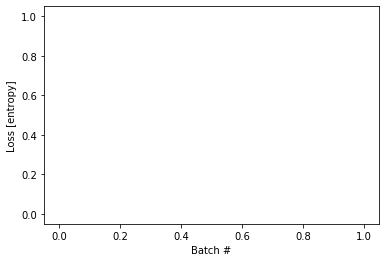

[]

In [15]:
tf.math.is_nan(loss_history)
loss_history = loss_history
fig2 = plt.figure()
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()
loss_history

In [16]:
print(snt.format_variables(radio_model.variables))

| Variable                  | Spec          | Trainable   | Device   |
|---------------------------+---------------+-------------+----------|
| CNN/conv0/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv0/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv1/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv1/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv2/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv2/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv3/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv3/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv4/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv4/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/conv5/conv_max_pool/w | f32[64,64,64] | True        | GPU      |
| CNN/conv5/conv_max_pool/b | f32[64]       | True        | GPU      |
| CNN/